In [147]:
import math
import datetime
import numpy as np
import re
import random

#from z3 import Int, IntVector, Bool, Optimize, Implies, And, Or, If, sat

from olsq.solve import OLSQ
from olsq.input import input_qasm
from olsq.output import output_qasm
from olsq.device import qcdevice
import pkgutil

from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model


import qiskit
import qiskit.qasm2
from qiskit import QuantumCircuit,transpile
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [148]:
def reorder_final(counts1,final_mapping):
    
    counts1_reordered=np.zeros(len(counts1))

    for q in counts1.keys():
        value=counts1[q]
        counts1_reordered[final_mapping[q]]=value

    return counts1_reordered

In [149]:
def compare_distribuitions(counts1,counts2):

    counts_diff={}
    mean_diff=0
    tot_count=0
    KL=0

    for string in counts1.keys():
        counts_diff[string]=None

    for string in counts1.keys():
        tot_count+=counts1[string]

    for string in counts1.keys():
        counts_diff[string]=(abs(counts1[string]/tot_count-counts2[string]/tot_count))

    for string in counts1.keys():
        mean_diff+=counts_diff[string]

    for string in counts1.keys():
        KL+=(counts1[string]/tot_count)*math.log((counts1[string]/tot_count)/(counts2[string]/tot_count))


    return mean_diff/2, max(counts_diff.values()),KL

In [150]:
def swap_to_cnot(qasm):


    # Regular expression to find the 'swaps q[x], q[y];' pattern
    pattern = r'swap q\[(\d+)\], q\[(\d+)\];'
    
    # Replacement function
    def replacement(match):
        x = match.group(1)
        y = match.group(2)
        return f'cx q[{x}], q[{y}]; cx q[{y}], q[{x}]; cx q[{x}], q[{y}];'
    
    # Perform the substitution
    result = re.sub(pattern, replacement, qasm)
    return result


In [151]:
def different_vector(solver,num_qubits,pi,t):
    #(solver.Value(pi[:][t]))!=(solver.Value(pi[:][t+1])):
    for q in range(num_qubits):
        if(solver.Value(pi[q][t]))==(solver.Value(pi[q][t+1])):
            pass
        else: 
            return True
    return False



def different_elements(solver,num_qubits,pi,t,pair):
    #(solver.Value(pi[:][t]))!=(solver.Value(pi[:][t+1])):
    q1=1000
    q2=1000

    while(q1-q2!=1 or ((q1 == pair[:][:] )or(q2 == pair[:][:] ))):
        flag=0
        numbers = list(range(num_qubits))  # Create a list of numbers from 0 to num-1
        random.shuffle(numbers)
        for q in numbers:
            if(solver.Value(pi[q][t]))!=(solver.Value(pi[q][t+1])):
                if flag==0:
                    q1=solver.Value(pi[q][t])
                    flag=1
                else:
                    q2=solver.Value(pi[q][t])

    return (q1,q2)

def num_diff_element(solver,num_qubits,pi,t):
    count=0
    for q in range(num_qubits):
        if(solver.Value(pi[q][t]))==(solver.Value(pi[q][t+1])):
            pass
        else: 
            count+=1
            
    return count/2

In [152]:
def print_histo(counts):    
# Convert the dictionary keys to integers for sorting
    # Get all possible binary values
    all_binary_values = ['{:04b}'.format(i) for i in range(2**len(list(counts.keys())[0]))]

    # Create a dictionary with zero counts for all possible binary values
    full_counts = {binary_value: counts.get(binary_value, 0) for binary_value in all_binary_values}

    # Sort keys and values based on keys (binary representation)
    sorted_counts = {k: full_counts[k] for k in sorted(full_counts.keys())}

    # Plot the histogram
    plt.bar(sorted_counts.keys(), sorted_counts.values())

    # Set labels and title
    plt.xlabel('Measured binary strings')
    plt.ylabel('Counts')
    plt.title('Measurments')

    # Diagonally rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

In [153]:

def collision_extracting(list_gate_qubits):
    """Extract collision relations between the gates,
    If two gates g_1 and g_2 both acts on a qubit (at different time),
    we say that g_1 and g_2 collide on that qubit, which means that
    (1,2) will be in collision list.

    Args:
        list_gate_qubits: a list of gates in OLSQ IR
    
    Returns:
        list_collision: a list of collisions between the gates
    """

    list_collision = list()
    # We sweep through all the gates.  For each gate, we sweep through all the
    # gates after it, if they both act on some qubit, append them in the list.
    for g in range(len(list_gate_qubits)):
        for gg in range(g + 1, len(list_gate_qubits)):
            
            if list_gate_qubits[g][0] == list_gate_qubits[gg][0]:
                    list_collision.append((g, gg))
                
            if len(list_gate_qubits[gg]) == 2:
                if list_gate_qubits[g][0] == list_gate_qubits[gg][1]:
                    list_collision.append((g, gg))
            
            if len(list_gate_qubits[g]) == 2:
                if list_gate_qubits[g][1] == list_gate_qubits[gg][0]:
                    list_collision.append((g, gg))
                if len(list_gate_qubits[gg]) == 2:
                    if list_gate_qubits[g][1] == list_gate_qubits[gg][1]:
                        list_collision.append((g, gg))
    
    return tuple(list_collision)

def dependency_extracting(list_gate_qubits, count_program_qubit: int):
    """Extract dependency relations between the gates.
    If two gates g_1 and g_2 both acts on a qubit *and there is no gate
    between g_1 and g_2 that act on this qubit*, we then say that
    g2 depends on g1, which means that (1,2) will be in dependency list.

    Args:
        list_gate_qubits: a list of gates in OLSQ IR
        count_program_qubit: the number of logical/program qubit
    
    Returns:
        list_dependency: a list of dependency between the gates
    """

    list_dependency = []
    list_last_gate = [-1 for i in range(count_program_qubit)]
    # list_last_gate records the latest gate that acts on each qubit.
    # When we sweep through all the gates, this list is updated and the
    # dependencies induced by the update is noted.
    for i, qubits in enumerate(list_gate_qubits):
        
        if list_last_gate[qubits[0]] >= 0:
            list_dependency.append((list_last_gate[qubits[0]], i))
        list_last_gate[qubits[0]] = i

        if len(qubits) == 2:
            if list_last_gate[qubits[1]] >= 0:
                list_dependency.append((list_last_gate[qubits[1]], i))
            list_last_gate[qubits[1]] = i

    return tuple(list_dependency)


class ILP1(OLSQ):
    def __init__(self, objective_name, mode):
        """Set the objective of OLSQ, and whether it is transition-based

        Args:
            objective_name: can be "depth", "swap", or "fidelity"
            mode: can be "normal" or "transition" (TB-OLSQ in the paper)       
        """
        
        if objective_name == "depth":
            self.objective_name = objective_name
        elif objective_name == "swap":
            self.objective_name = objective_name
        elif objective_name == "fidelity":
            self.objective_name = objective_name
        else:
            raise ValueError("Invalid Objective Name")

    

        # These values should be updated in setdevice(...)
        self.device = None
        self.count_physical_qubit = 0
        self.list_qubit_edge = []
        self.swap_duration = 0

        # These values should be updated in setprogram(...)
        self.list_gate_qubits = []
        self.count_program_qubit = 0
        self.list_gate_name = []
        
        # bound_depth is a hyperparameter
        self.bound_depth = 0

        self.inpput_dependency = False
        self.list_gate_dependency = []

    def setdevice(self, device: qcdevice):
        """Pass in parameters from the given device.  If in TB mode,
           swap_duration is set to 1 without modifying the device.

        Args:
            device: a qcdevice object for OLSQ
        """
     
        self.device = device
        self.count_physical_qubit = device.count_physical_qubit
        self.list_qubit_edge = device.list_qubit_edge
        self.swap_duration = device.swap_duration
        

          

    def setprogram(self, program, input_mode: str = None):
        """Translate input program to OLSQ IR, and set initial depth
        An example of the intermediate representation is shown below.
        It contains three things: 1) the number of qubit in the program,
        2) a list of tuples representing qubit(s) acted on by a gate,
        the tuple has one index if it is a single-qubit gate,
        two indices if it is a two-qubit gate, and 3) a list of
        type/name of each gate, which is not important to OLSQ,
        and only needed when generating output.
        If in TB mode, initial depth=1; in normal mode, we perform ASAP
        scheduling without consideration of SWAP to calculate depth.

        Args:
            program: a qasm string, or a list of the three things in IR.
            input_mode: (optional) can be "IR" if the input has ben
                translated to OLSQ IR; can be "benchmark" to use one of
                the benchmarks.  Default mode assumes qasm input.

        Example:
            For the following circuit
                q_0: ───────────────────■───
                                        │  
                q_1: ───────■───────────┼───
                     ┌───┐┌─┴─┐┌─────┐┌─┴─┐
                q_2: ┤ H ├┤ X ├┤ TDG ├┤ X ├─
                     └───┘└───┘└─────┘└───┘ 
            count_program_qubit = 3
            gates = ((2,), (1,2), (2,), (0,1))
            gate_spec = ("h", "cx", "tdg", "cx")
        """
        
        if input_mode == "IR":
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]
        elif input_mode == "benchmark":
            f = pkgutil.get_data(__name__, "benchmarks/" + program + ".qasm")
            program = input_qasm(f.decode("utf-8"))
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]
        else:
            program = input_qasm(program)
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]

        # calculate the initial depth
        
        push_forward_depth = [0 for i in range(self.count_program_qubit)]
        for qubits in self.list_gate_qubits:
            if len(qubits) == 1:
                push_forward_depth[qubits[0]] += 1
            else:
                tmp_depth = push_forward_depth[qubits[0]]
                if tmp_depth < push_forward_depth[qubits[1]]:
                    tmp_depth = push_forward_depth[qubits[1]]
                    push_forward_depth[qubits[1]] = tmp_depth + 1
                push_forward_depth[qubits[0]] = tmp_depth + 1
        self.bound_depth = max(push_forward_depth)

    def setdependency(self, dependency: list):
        """Specify dependency (non-commutation)

        Args:
            dependency: a list of gate index pairs
        
        Example:
            For the following circuit
                q_0: ───────────────────■───
                                        │  
                q_1: ───────■───────────┼───
                     ┌───┐┌─┴─┐┌─────┐┌─┴─┐
                q_2: ┤ H ├┤ X ├┤ TDG ├┤ X ├─
                     └───┘└───┘└─────┘└───┘ 
                gate   0    1     2     3
            dependency = [(0,1), (1,2), (2,3)]

            However, for this QAOA subcircuit (ZZ gates may have phase
            parameters, but we neglect them for simplicity here)
                         ┌──┐ ┌──┐
                q_0: ────┤ZZ├─┤  ├─
                     ┌──┐└┬─┘ │ZZ│  
                q_1: ┤  ├─┼───┤  ├─
                     │ZZ│┌┴─┐ └──┘
                q_2: ┤  ├┤ZZ├──────
                     └──┘└──┘ 
                gate   0   1   2
            dependency = []    # since ZZ gates are commutable
        """
        self.list_gate_dependency = dependency
        self.inpput_dependency = True

    def solve(self, output_mode: str = None, output_file_name: str = None):
        """Formulate an SMT, pass it to z3 solver, and output results.
        CORE OF OLSQ, EDIT WITH CARE.

        Args:
            output_mode: "IR" or left to default.
            output_file_name: a file to store the IR output or qasm.
        
        Returns:
            a list of results depending on output_mode
            "IR": 
            | list_scheduled_gate_name: name/type of each gate
            | list_scheduled_gate_qubits: qubit(s) each gate acts on
            | final_mapping: logical qubit |-> physical qubit in the end 
            | objective_value: depth/#swap/fidelity depending on setting
            None:
              a qasm string
              final_mapping
              objective_value
        """

        objective_name = self.objective_name
        device = self.device
        list_gate_qubits = self.list_gate_qubits
        count_program_qubit = self.count_program_qubit
        list_gate_name = self.list_gate_name
        count_physical_qubit = self.count_physical_qubit
        list_qubit_edge = self.list_qubit_edge
        swap_duration = self.swap_duration
        bound_depth = self.bound_depth
        

         
      
        # pre-processing

        count_qubit_edge = len(list_qubit_edge)
        count_gate = len(list_gate_qubits)
        if self.objective_name == "fidelity":
            list_logfidelity_single = [
                int(1000 * math.log(device.list_fidelity_single[n]))
                for n in range(count_physical_qubit)]
            list_logfidelity_two = [
                int(1000 * math.log(device.list_fidelity_two[k]))
                for k in range(count_qubit_edge)]
            list_logfidelity_measure = [
                int(1000 * math.log(device.list_fidelity_measure[n]))
                for n in range(count_physical_qubit)]
        list_gate_two = list()
        list_gate_single = list()
        for l in range(count_gate):
            if len(list_gate_qubits[l]) == 1:
                list_gate_single.append(l)
            else:
                list_gate_two.append(l)

        # list_adjacency_qubit takes in a physical qubit index _p_, and
        # returns the list of indices of physical qubits adjacent to _p_
        list_adjacent_qubit = list()
        # list_span_edge takes in a physical qubit index _p_,
        # and returns the list of edges spanned from _p_
        list_span_edge = list()
        for n in range(count_physical_qubit):
            list_adjacent_qubit.append(list())
            list_span_edge.append(list())
        for k in range(count_qubit_edge):
            list_adjacent_qubit[list_qubit_edge[k][0]].append(list_qubit_edge[k][1])
            list_adjacent_qubit[list_qubit_edge[k][1]].append(list_qubit_edge[k][0])
            list_span_edge[list_qubit_edge[k][0]].append(k)
            list_span_edge[list_qubit_edge[k][1]].append(k)

        print(list_span_edge)
        print('list_gate_qubits')
        print(list_gate_qubits)

        print('list_qubit_edge')
        print(list_qubit_edge)

        # if_overlap_edge takes in two edge indices _e_ and _e'_,
        # and returns whether or not they overlap
        if_overlap_edge = [[0] * count_qubit_edge
            for k in range(count_qubit_edge)]
        # list_over_lap_edge takes in an edge index _e_,
        # and returnsthe list of edges that overlap with _e_
        list_overlap_edge = list()
        # list_count_overlap_edge is the list of lengths of
        # overlap edge lists of all the _e_
        list_count_overlap_edge = list()
        for k in range(count_qubit_edge):
            list_overlap_edge.append(list())
        for k in range(count_qubit_edge):
            for kk in range(k + 1, count_qubit_edge):
                if (   (list_qubit_edge[k][0] == list_qubit_edge[kk][0]
                        or list_qubit_edge[k][0] == list_qubit_edge[kk][1])
                    or (list_qubit_edge[k][1] == list_qubit_edge[kk][0]
                        or list_qubit_edge[k][1] == list_qubit_edge[kk][1]) ):
                    list_overlap_edge[k].append(kk)
                    list_overlap_edge[kk].append(k)
                    if_overlap_edge[kk][k] = 1
                    if_overlap_edge[k][kk] = 1
        for k in range(count_qubit_edge):
            list_count_overlap_edge.append(len(list_overlap_edge[k]))

        if not self.inpput_dependency:
            list_gate_dependency = collision_extracting(list_gate_qubits)
        else:
            list_gate_dependency = self.list_gate_dependency

        # index function: takes two physical qubit indices _p_ and _p'_,
        # and returns the index of the edge between them if there is one
        map_edge_index = [[0] * count_physical_qubit] * count_physical_qubit
        for k in range(count_qubit_edge):
            map_edge_index[list_qubit_edge[k][0]][list_qubit_edge[k][1]] = k
            map_edge_index[list_qubit_edge[k][1]][list_qubit_edge[k][0]] = k

        not_solved = True
        start_time = datetime.datetime.now()
        
        
    
        model = cp_model.CpModel()
        solver = cp_model.CpSolver()
        solver.parameters.linearization_level = 2 # Use SCIP as the backend solver

        status = False
        start_time = datetime.datetime.now()

        space =[]
        for g in range(count_gate):
            if len(list_gate_qubits[g])==2:
                space.append((list_gate_qubits[g][0],list_gate_qubits[g][1]))

            if len(list_gate_qubits[g])==1:
                space.append((list_gate_qubits[g][0],))

            print(f'space[{g}]={space[g]}')

        dep_extract=dependency_extracting(list_gate_qubits, count_program_qubit)
        time = np.zeros(count_gate, dtype=int)
        for k in range (len(list_gate_qubits)):
            for kk in range (0,k):
                if (kk,k) in dep_extract:
                    time[k] = time[kk]+1

        for k in range (len(list_gate_qubits)):
            print(f'time[{k}]={time[k]}')

        pi = [[model.new_int_var(0,count_physical_qubit,f'map_q{i}_t{j}') for j in range(bound_depth)]
                    for i in range(count_physical_qubit)]
            
            #z = model.new_int_var(0,100,'num_swap')
        z = [model.new_int_var(0, 100, f'num_swap_{l}') for l in range(bound_depth)]

    #################################################################################################################################################
        for l in range(bound_depth):
            model.AddAllDifferent(pi[q][l] for q in range(count_physical_qubit))

        for l in range(bound_depth):
            for q in range(count_physical_qubit):
                model.Add(pi[q][l]<count_physical_qubit)

        for l in range(bound_depth):
            for g in range(count_gate):
                if time[g]==l and len(space[g])==2:
                    p=space[g][0]
                    q=space[g][1]
                    model.AddAbsEquality(1,pi[p][l]-pi[q][l])

        for l in range(bound_depth-1):
            for q in range(count_physical_qubit):
                model.Add(pi[q][l]-pi[q][l+1]<=1)
                model.Add(pi[q][l+1]-pi[q][l]<=1)

        # for l in range(bound_depth-1):
        #     for g in range(count_gate):
        #         if time[g]==l:
        #             p=space[g][0]
        #             q=space[g][1]
        #             model.Add(pi[p][l]-pi[q][l+1]<=1)
        #             model.Add(pi[q][l+1]-pi[p][l]<=1)

        for l in range(bound_depth-1):
            for q in range(count_physical_qubit):
                model.Add(pi[q][l]-pi[q][l+1]<=z[l])
                model.Add(pi[q][l+1]-pi[q][l]<=z[l])
        

            # Objective function
        model.minimize(sum(z[l]for l in range(bound_depth)))
            

            # Create a solver and solve the model
        solver = cp_model.CpSolver()
                

        status = solver.solve(model)

        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            print(f'Solution found:')
            for m in range(count_program_qubit):
                for t in range(bound_depth):
                    print(f'pi[{m}][{t}] = {solver.Value(pi[m][t])}')

            for l in range(bound_depth):
                print(f'z = {solver.Value(z[l])}')

            
        else:
                #bound_depth = int(1.3 * bound_depth)
            bound_depth+=1
            print('No solution found')

##################################################################################################
        
        print(f"Compilation time = {datetime.datetime.now() - start_time}.")

        #print(model.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

        model.export_to_file('model.txt')

        # post-processing
        result_time = []
        #result_depth = solver.Value(depth)
        #result_depth = solver.Value(bound_depth)
        result_depth=bound_depth

        #space
        #time
        #list_gate_qubits
        #list_gate_name
        qasm_output=f'''
            OPENQASM 2.0;
            include "qelib1.inc";

            qreg q[{count_program_qubit}];
            creg c[{count_program_qubit}];

            '''

        for t in range(bound_depth):
            flag=0
            for g in range(count_gate):
                if time[g]==t and len(space[g])==2:
                    q_ctlr=space[g][0]
                    q_targ=space[g][1]
                    qasm_output+=f'cx q[{solver.Value(pi[q_ctlr][t])}], q[{solver.Value(pi[q_targ][t])}];\n'
                if time[g]==t and len(space[g])==1:
                    q=space[g][0]
                    qasm_output+=f'{list_gate_name[g]} q[{solver.Value(pi[q][t])}];\n'
                    #qasm_output+=f'x q[{solver.Value(pi[q][t])}];\n'

                count=0
                if t<bound_depth-1:
                    if g<count_gate-1:
                        pair=[]
                        count=0
                        if different_vector(solver,count_program_qubit,pi,t) and time[g+1]==t+1 :
                        #(solver.Value(pi[:][t]))!=(solver.Value(pi[:][t+1])):
                            num_different_couples=num_diff_element(solver,count_program_qubit,pi,t)
                            while( count < num_different_couples ):
                                count=count+1
                                pair_to_swap = different_elements(solver,count_program_qubit,pi,t,pair)
                                pair.append(pair_to_swap)
                                qasm_output+=f'swap q[{pair[-1][0]}], q[{pair[-1][1]}];\n'
                                
                            #which indices are different
                            #write a swap in qasm file between those


        

        for q in range(count_program_qubit):
            qasm_output+=f'measure q[{solver.Value(pi[q][bound_depth-1])}] -> c[{q}];\n'


        

        #   schedule all of gates at that time
        #   if next time mapping is different 
        #       insert swap
        #
        #



        # for l in range(count_gate):
        #     result_time.append(solver.Value(time[l]))
        
        # list_result_swap = []
        # for k in range(count_qubit_edge):
        #     for t in range(result_depth):
        #         if solver.Value(sigma[k][t]):
        #             list_result_swap.append((k, t))
        #             #print(f"SWAP on physical edge ({list_qubit_edge[k][0]}, {list_qubit_edge[k][1]}) at time {t}")
        
        # for l in range(count_gate):
        #     if len(list_gate_qubits[l]) == 1:
        #         qq = list_gate_qubits[l][0]
        #         tt = result_time[l]
        #         #print(f"Gate {l}: {list_gate_name[l]} {qq} on qubit {solver.Value(pi[qq][tt])} at time {tt}")
        #     else:
        #         qq = list_gate_qubits[l][0]
        #         qqq = list_gate_qubits[l][1]
        #         tt = result_time[l]
        #         #print(f"Gate {l}: {list_gate_name[l]} {qq}, {qqq} on qubits {solver.Value(pi[qq][tt])} and {solver.Value(pi[qqq][tt])} at time {tt}")
        
        # objective_value = solver.Value(depth)
        # #print(f"result circuit depth = {objective_value}.")
        
        #list_scheduled_gate_qubits = [[] for _ in range(result_depth)]
        #list_scheduled_gate_name = [[] for _ in range(result_depth)]
        
        # for l in range(count_gate):
        #     t = result_time[l]
        #     list_scheduled_gate_name[t].append(list_gate_name[l])
            
        #     if l in list_gate_single:
        #         q = solver.Value(space[l])
        #         list_scheduled_gate_qubits[t].append((q,))
        #     elif l in list_gate_two:
        #         q0, q1 = list_gate_qubits[l]
        #         tmp_t = t
        #         q0 = solver.Value(pi[q0][tmp_t])
        #         q1 = solver.Value(pi[q1][tmp_t])
        #         list_scheduled_gate_qubits[t].append((q0, q1))
        #     else:
        #         raise ValueError("Expect single-qubit or two-qubit gate.")
        
        # final_mapping = []
        # for m in range(count_program_qubit):
        #     tmp_depth = result_depth - 1
        #     final_mapping.append(solver.Value(pi[m][tmp_depth]))

        # for (k, t) in list_result_swap:
        #     q0 = list_qubit_edge[k][0]
        #     q1 = list_qubit_edge[k][1]
        #     if self.swap_duration == 1:
        #         list_scheduled_gate_qubits[t].append((q0, q1))
        #         list_scheduled_gate_name[t].append("swap")
        #     elif self.swap_duration == 3:
        #         list_scheduled_gate_qubits[t].append((q0, q1))
        #         list_scheduled_gate_name[t].append("CX")
        #         list_scheduled_gate_qubits[t - 1].append((q1, q0))
        #         list_scheduled_gate_name[t - 1].append("CX")
        #         list_scheduled_gate_qubits[t - 2].append((q0, q1))
        #         list_scheduled_gate_name[t - 2].append("CX")
        #     else:
        #         raise ValueError("Expect SWAP duration one, or three")
            
##################################################################################################
        z_tot=0
        for l in range(bound_depth):
            z_tot+=solver.Value(z[l])

        return qasm_output, z_tot

In [154]:
qasm_input='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
creg c[4];

// Initial state preparation: Apply Hadamard gates to all qubits

cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];


'''

qasm_input_QAOA_3='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];

// Initial state preparation: Apply Hadamard gates to all qubits

cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[1];
cx q[0], q[2];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
'''

qasm_input_QAOA_4='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
creg c[4];

// Initial state preparation: Apply Hadamard gates to all qubits

cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];



cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
'''

qasm_input_QAOA_5='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];

rz(0) q[0];
cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(4) q[4];

rz(0) q[0];
cx q[0], q[1];

cx q[0], q[2];

rz(1) q[1];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(4) q[4];
rz(0) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
'''

qasm_input_QAOA_6='''

OPENQASM 2.0;
include "qelib1.inc";

qreg q[6];
creg c[6];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
'''
qasm_input_QAOA_7='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[7];
creg c[7];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
'''

qasm_input_QAOA_8='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[8];
creg c[8];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
'''

qasm_input_QAOA_9='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[9];
creg c[9];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
'''

qasm_input_QAOA_10='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[10];
creg c[10];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];
h q[9];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];

cx q[0], q[9];
rz(1.3) q[9];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];

cx q[0], q[9];
rz(1.3) q[9];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
measure q[9] -> c[9];
'''

     ┌───┐┌───────┐                                                          »
q_0: ┤ H ├┤ Rz(0) ├──■─────────────■─────────────■─────────────■─────────────»
     ├───┤└───────┘┌─┴─┐┌───────┐  │             │             │             »
q_1: ┤ H ├─────────┤ X ├┤ Rz(1) ├──┼─────────────┼─────────────┼─────────────»
     ├───┤         └───┘└───────┘┌─┴─┐┌───────┐  │             │             »
q_2: ┤ H ├───────────────────────┤ X ├┤ Rz(2) ├──┼─────────────┼─────────────»
     ├───┤                       └───┘└───────┘┌─┴─┐┌───────┐  │             »
q_3: ┤ H ├─────────────────────────────────────┤ X ├┤ Rz(3) ├──┼─────────────»
     ├───┤                                     └───┘└───────┘┌─┴─┐┌─────────┐»
q_4: ┤ H ├───────────────────────────────────────────────────┤ X ├┤ Rz(1.3) ├»
     ├───┤                                                   └───┘└─────────┘»
q_5: ┤ H ├───────────────────────────────────────────────────────────────────»
     ├───┤                                          

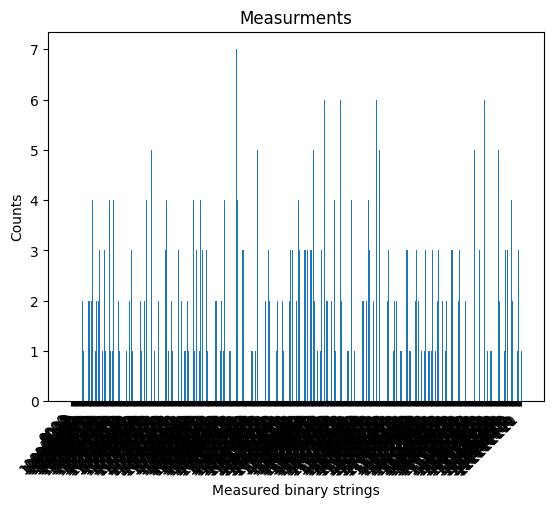

[[0], [0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7]]
list_gate_qubits
((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (0,), (0, 1), (1,), (0, 2), (2,), (0, 3), (3,), (0, 4), (4,), (0, 5), (5,), (0, 6), (6,), (0, 7), (7,), (0, 8), (8,), (0,), (0, 1), (1,), (0, 2), (2,), (0, 3), (3,), (0, 4), (4,), (0, 5), (5,), (0, 6), (6,), (0, 7), (7,), (0, 8), (8,), (0,))
list_qubit_edge
((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8))
space[0]=(0,)
space[1]=(1,)
space[2]=(2,)
space[3]=(3,)
space[4]=(4,)
space[5]=(5,)
space[6]=(6,)
space[7]=(7,)
space[8]=(8,)
space[9]=(0,)
space[10]=(0, 1)
space[11]=(1,)
space[12]=(0, 2)
space[13]=(2,)
space[14]=(0, 3)
space[15]=(3,)
space[16]=(0, 4)
space[17]=(4,)
space[18]=(0, 5)
space[19]=(5,)
space[20]=(0, 6)
space[21]=(6,)
space[22]=(0, 7)
space[23]=(7,)
space[24]=(0, 8)
space[25]=(8,)
space[26]=(0,)
space[27]=(0, 1)
space[28]=(1,)
space[29]=(0, 2)
space[30]=(2,)
space[31]=(0, 3)
space[32]=(3,)
space[33]=(0, 4)
space[34]=(4,)

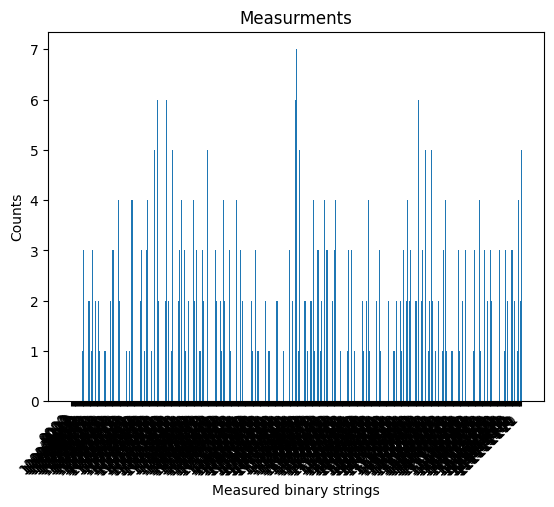

total variation distance: Mean_diff/2, max_diff, KL Divergence


KeyError: '111101001'

In [155]:
solver = ILP1("depth", "normal")


bowtie_connections = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8)]
bowtie_dev = qcdevice("bowtie", nqubits=9, connection=bowtie_connections, 
                  swap_duration=1)

solver.setdevice(bowtie_dev)



circuit = QuantumCircuit()
circuit = circuit.from_qasm_str(str(qasm_input_QAOA_9))
#print(qasm_input1)
print(circuit)

simulator = AerSimulator()

# Run and get counts
result = simulator.run(circuit,shots=1000).result()
counts = result.get_counts(circuit)
#plot_histogram(counts)
#plt.savefig('histogram.png')

print_histo(counts)

solver.setprogram(qasm_input_QAOA_9)


qasm,z_tot= solver.solve()

qasm_output_cnot=swap_to_cnot(qasm)


#print(qasm)
circuit0 = QuantumCircuit()
circuit0 = circuit0.from_qasm_str(str(qasm))
print(circuit0)

circuit1 = QuantumCircuit()
circuit1 = circuit1.from_qasm_str(str(qasm_output_cnot))
print(circuit1)

result1 = simulator.run(circuit1,shots=1000).result()
counts1 = result1.get_counts(circuit1)
print(counts1)
print_histo(counts1)

print('total variation distance: Mean_diff/2, max_diff, KL Divergence')
print(compare_distribuitions(counts,counts1))

print('depth before')
print(circuit.depth())

print('depth after')
print(circuit1.depth())

print('depth after analytic calculus')
print(circuit.depth()+3*z_tot)



In [ ]:
print('depth before')
print(circuit.depth())

print('depth after')
print(circuit1.depth())

print('depth after analytic calculus')
print(circuit.depth()+3*z_tot)

depth before
19
depth after
99
depth after analytic calculus
46
